# Analysis of mutated positions against wild-type partner

In [1]:
# import required modules
import pickle5 as pickle
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('../../code')
import utils

In [2]:
# infos and variables
DataPath = ".." # the folder containing the required files
OptFN = f"{DataPath}/options_full.ini"
ZScoreTreshold = 1
WtSD = 0

In [3]:
## load required data
# the options
AllowedPars = ["Partners"]
OptionsDic = utils.get_OptionsIPyNB(OptFN, AllowedPars)
# the folowing lines are required to correct relative path
for key in OptionsDic.keys():
    MyValue = OptionsDic[key]
    if "../" in MyValue:
        OptionsDic[key] = MyValue.replace("../", "{}/../".format(DataPath))

ComplexesL = utils.double_split(OptionsDic["Partners"], ";", "~")[0]

# the dBCDic
dBCDic = {} 
with open(r"{}/SR_dBC_{}_vs_{}.pkl".format(DataPath,ComplexesL[0], ComplexesL[1]), "rb") as input_file:
    dBCDic = pickle.load(input_file)

In [4]:
# filter dBCDic and print associated relevant information 
for complex in dBCDic.keys():
    print("Complex '{}' has {} double barcodes".format(complex, len(dBCDic[complex])))

# pA_PosLB = set()
# pB_PosLB = set() 
filtered_dBCDic = {}
filtered_dBCWtDic = {}
WT_types = ['WtOK', 'SynOK']
for complex in dBCDic.keys():
    partners = complex.split("_vs_")
    pA_name = partners[0]
    pB_name = partners[1]
    for dBC in dBCDic[complex].keys():
        if 'NormEnrich' in dBCDic[complex][dBC].keys():
            
            # partner A infos
            pA_NT = dBCDic[complex][dBC]['Before'][0]
            pA_AA = dBCDic[complex][dBC]['Before'][1]
            try:
                pA_pos = int(pA_AA[1:-1])
            except:
                pA_pos = pA_AA[1:-1]
            pA_type = dBCDic[complex][dBC]['Before'][2]
     
            # partner B infos
            pB_NT = dBCDic[complex][dBC]['Before'][3]
            pB_AA = dBCDic[complex][dBC]['Before'][4]
            try:
                pB_pos = int(pB_AA[1:-1])
            except:
                pB_pos = pB_AA[1:-1]
            pB_type = dBCDic[complex][dBC]['Before'][5]
            
            # NormEnrich
            NormEnrich = dBCDic[complex][dBC]['NormEnrich']
            # pA_PosLB.add( pA_pos )
            # pB_PosLB.add( pB_pos )
            if (pA_type in WT_types) and (pB_type not in WT_types):
                # print("'{}'".format(pB_pos))
                if isinstance(pB_pos, int):
                    # print("is integer")
                    if complex not in filtered_dBCDic.keys():
                        filtered_dBCDic[complex] = { dBC : [pB_name, pB_NT, pB_AA, pB_pos, pB_type, NormEnrich ] }
                    else: 
                        filtered_dBCDic[complex][dBC] = [pB_name, pB_NT, pB_AA, pB_pos, pB_type, NormEnrich ] # [name, NT change, AA change, pos, type, Normenrich ] 
                # else:
                #     print("is NOT integer")
            elif (pB_type in WT_types) and (pA_type not in WT_types):
                # print("'{}'".format(pA_pos))
                if isinstance(pA_pos, int):
                    # print("is integer")
                    if complex not in filtered_dBCDic.keys():
                        filtered_dBCDic[complex] = { dBC : [ pA_name, pA_NT, pA_AA, pA_pos, pA_type, NormEnrich ] }
                    else: 
                        filtered_dBCDic[complex][dBC] = [ pA_name, pA_NT, pA_AA, pA_pos, pA_type, NormEnrich ]  # [name, NT change, AA change, pos, type, Normenrich ]
            elif (pA_type in WT_types) and (pB_type in WT_types):
                if complex not in filtered_dBCWtDic.keys():
                        filtered_dBCWtDic[complex] =  [ NormEnrich ] 
                else: 
                        filtered_dBCWtDic[complex].append(NormEnrich)  # [name, NT change, AA change, pos, type, Normenrich ]
                
                # else:
                #     print("is NOT integer")
        #     else:
        #         continue
        # else:
        #     continue
# print(pA_PosLB, pB_PosLB)
pA_PosL = set()
pB_PosL = set()
for complex in filtered_dBCDic.keys():
    partners = complex.split("_vs_")
    pA_name = partners[0]
    pB_name = partners[1]
    for dBC in filtered_dBCDic[complex].keys():
        # print(filtered_dBCDic[complex][dBC])
        if filtered_dBCDic[complex][dBC][0] == pA_name :
            pA_PosL.add( filtered_dBCDic[complex][dBC][3] )
        elif filtered_dBCDic[complex][dBC][0] == pB_name:
            pB_PosL.add( filtered_dBCDic[complex][dBC][3] )
        else:
            print("'{}' | @{}@".format(pA_name, filtered_dBCDic[complex][dBC][3]))
    print(f"Positions retained for {pA_name} (with WT counterpart): {pA_PosL}")
    print(f"Positions retained for {pB_name} (with WT counterpart): {pB_PosL}\n")
         

dBCDic = filtered_dBCDic
for complex in dBCDic.keys():
    print("{} valid double barcodes (mutant vs WT) with normalized enrichment were retained for complex '{}'".format(len(dBCDic[complex]), complex))
    dBCWT_start = len(filtered_dBCWtDic[complex])
    filtered_dBCWtDic[complex] = utils.remove_outiers(filtered_dBCWtDic[complex], ZScoreTreshold)
    WtEnrich = utils.statistics.mean(filtered_dBCWtDic[complex]) 
    WtSD = utils.statistics.stdev(filtered_dBCWtDic[complex])
    print("{} valid double barcodes (WT vs WT) with normalized enrichment were retained from {} for complex '{}'. WT enrichment: {:.3} {} {:.3} ".format(len(filtered_dBCWtDic[complex]), dBCWT_start, complex, WtEnrich, u"\u00B1", WtSD))
    

Complex 'VN1551_VHH2_vs_VN1554_TNF2' has 76810 double barcodes
Complex 'VN1554_VHH2BC_vs_VN1554_TNF2' has 330 double barcodes
Positions retained for VN1551_VHH2 (with WT counterpart): {32, 33, 98, 35, 99, 101, 103, 74, 50, 53, 54, 56, 57, 30, 31}
Positions retained for VN1554_TNF2 (with WT counterpart): {32, 97, 135, 137, 75, 77, 79, 81, 146, 147, 88, 89, 90, 92, 95}

Positions retained for VN1554_VHH2BC (with WT counterpart): {32, 33, 98, 35, 99, 101, 103, 74, 50, 53, 54, 56, 57, 30, 31}
Positions retained for VN1554_TNF2 (with WT counterpart): {32, 97, 135, 137, 75, 77, 79, 81, 146, 147, 88, 89, 90, 92, 95}

19491 valid double barcodes (mutant vs WT) with normalized enrichment were retained for complex 'VN1551_VHH2_vs_VN1554_TNF2'
2048 valid double barcodes (WT vs WT) with normalized enrichment were retained from 2324 for complex 'VN1551_VHH2_vs_VN1554_TNF2'. WT enrichment: 1.0 ± 0.305 
212 valid double barcodes (mutant vs WT) with normalized enrichment were retained for complex 'VN1

In [5]:
# delete this cell
max = 10
for complex in dBCDic.keys():
    i = 0
    for dBC in dBCDic[complex]:
        if i <= max:
            if dBCDic[complex][dBC][0] != 'VN1551_VHH2':
                print("{}:\n{}".format(dBC, dBCDic[complex][dBC] ))
                i += 1
            

TATTGTTTTGTTTTGTCTTGTTTCGATTTGTTTT:CCCTGTCACGTACCGACATGCCCCGCCTTGTCTT:
['VN1554_TNF2', 'A241T,G242T,C243T', 'S81F', 81, 'MutOK', 0.1131058524379356]
CCACGACCCGCCCCGACACGACATGCCACGCCAC:ACACGCTCTGCCACGCCATGCTCCGTCCTGTCAC:
['VN1554_TNF2', 'A268T,A269G,A270G', 'K90W', 90, 'MutOK', 0.10836037131405464]
CTTCGATCCGCTACGTTACGCTATGTTCTGACTC:TAATGACCTGTAACGCCTCGTCCCGAACTGCCAT:
['VN1554_TNF2', 'A270C', 'K90N', 90, 'MutOK', 0.16196658899237146]
CAACGAAACGACACGAAACGTAACGCATCGAATC:TTCCGTTTTGTTTTGTTTTGTTTTGTTTTGTATT:
['VN1554_TNF2', 'G440C,C441T', 'S147T', 147, 'MutOK', 0.9593639783966936]
TCTTGCATCGCAACGAACCGACATGCACCGTCAT:CCCCGAAACGAACCGCCCCGCCCCGCATCGCCTC:
['VN1554_TNF2', 'A268C,A269G,A270T', 'K90R', 90, 'MutOK', 0.9954251602923581]
TCTTGCATCGCAACGAACCGACATGCACCGTCAT:CTTTGTCTCGTTCCGTCATGTCTTGTTTCGCTTT:
['VN1554_TNF2', 'G440A,C441G', 'S147K', 147, 'MutOK', 0.8443067584442412]
TCTTGCATCGCAACGAACCGACATGCACCGTCAT:TTTTGCAATGCTCTGTTTTGTTCTGCTTTGTTTT:
['VN1554_TNF2', 'A268C,A269G,A270C', 'K90R', 90, 'Mut

In [6]:
# create data structure focusing each observed partner position and nt mutation 
ByPosDic = {}
for complex in dBCDic.keys():
    for dBC in dBCDic[complex]:
        partner = dBCDic[complex][dBC][0]
        nt = dBCDic[complex][dBC][1]
        aa = dBCDic[complex][dBC][2]
        muta = "{}({})".format(aa,nt)
        try:
            pos = int(dBCDic[complex][dBC][3])
            enrich = dBCDic[complex][dBC][-1]
            if partner in ByPosDic.keys():
                if pos in ByPosDic[partner].keys():
                    if muta in ByPosDic[partner][pos].keys():
                        ByPosDic[partner][pos][muta][0].append(enrich)
                    else:
                        ByPosDic[partner][pos][muta] = [ [ enrich ], 0, 0 ]
                else:
                    ByPosDic[partner][pos] = { muta : [ [ enrich ], 0, 0 ] }
            else:
                ByPosDic[partner] = { pos : { muta: [ [ enrich], 0, 0 ] }  
                                    }
        except:
            continue
            
del dBCDic

In [7]:
# get mean and SD for each mutant against WT
for partner in ByPosDic.keys():
    print("Partner {} has {} positions: {} ".format(partner, len(ByPosDic[partner].keys()), list(ByPosDic[partner].keys())))
    for pos in ByPosDic[partner].keys():
        for muta in ByPosDic[partner][pos].keys():
            NewEnrichList = utils.remove_outiers(ByPosDic[partner][pos][muta][0], ZScoreTreshold)
            ByPosDic[partner][pos][muta][0] = NewEnrichList
            if len(NewEnrichList) > 1:
                Mean = utils.statistics.mean(NewEnrichList) 
                SD = utils.statistics.stdev(NewEnrichList)
            else:
                Mean = float(NewEnrichList[0])
                SD = float(0)
            ByPosDic[partner][pos][muta][1] = Mean
            ByPosDic[partner][pos][muta][2] = SD
#            print("{} | {}: {:.3} {} {:.3} ({} value(s) retained)".format(partner, muta, Mean, u"\u00B1", SD, len(ByPosDic[partner][pos][muta][0])))

Partner VN1551_VHH2 has 15 positions: [35, 103, 57, 101, 54, 33, 98, 50, 32, 74, 56, 53, 31, 99, 30] 
Partner VN1554_TNF2 has 15 positions: [81, 90, 147, 95, 137, 77, 135, 32, 146, 92, 75, 79, 89, 88, 97] 


In [8]:
#### ByPosDic[partner] = dict(sorted(ByPosDic[partner].items()))
OutputInfo = False # assing it to True to print written information

for partner in ByPosDic.keys():
    if OutputInfo == True: 
        print("####### {} #########".format(partner))
    # print(ByPosDic[partner].keys())
    PosL = sorted(ByPosDic[partner].keys())
    # print(PosL)
    for pos in PosL:
        if OutputInfo == True: 
            print("**** Position: {} ******".format(pos))
        MutaL = sorted(ByPosDic[partner][pos].keys())
        for muta in MutaL:
            Mean = ByPosDic[partner][pos][muta][1]
            SD = ByPosDic[partner][pos][muta][2]
            if OutputInfo == True: 
               print("{}: {:.3} {} {:.3} ({} value(s) retained)".format(muta, Mean, u"\u00B1", SD, len(ByPosDic[partner][pos][muta][0])))
    print("\n\n")

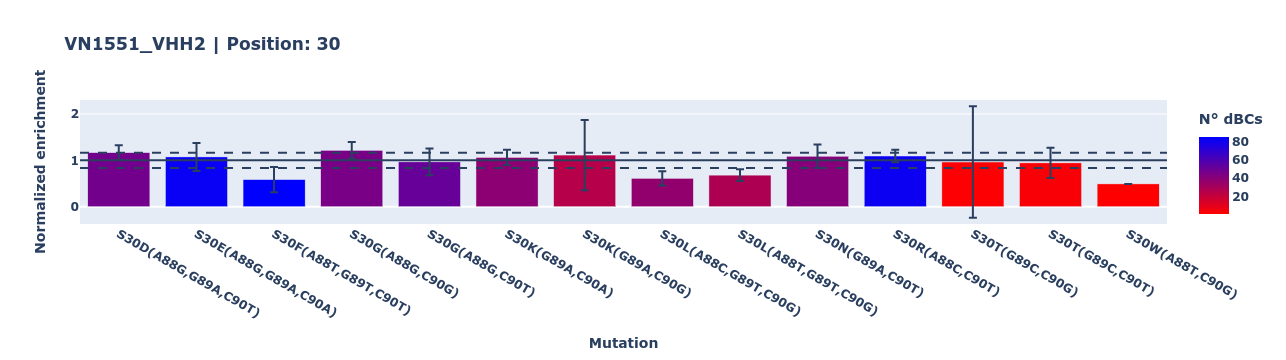

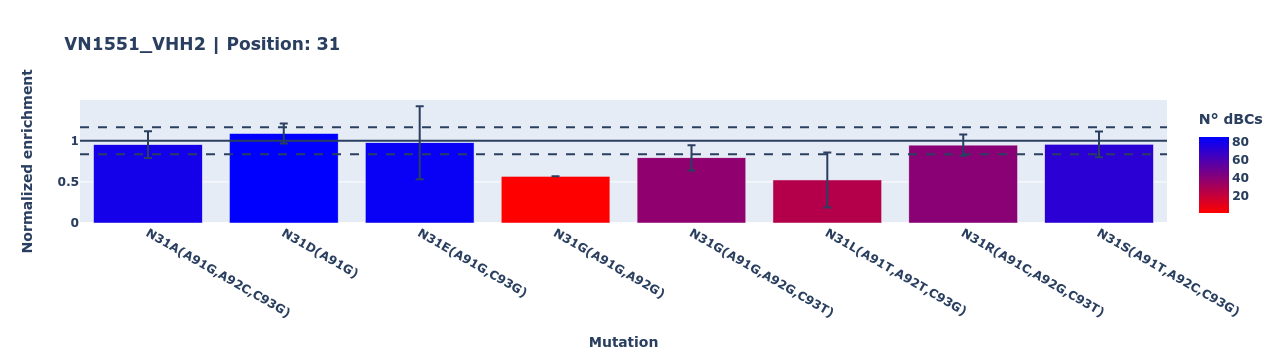

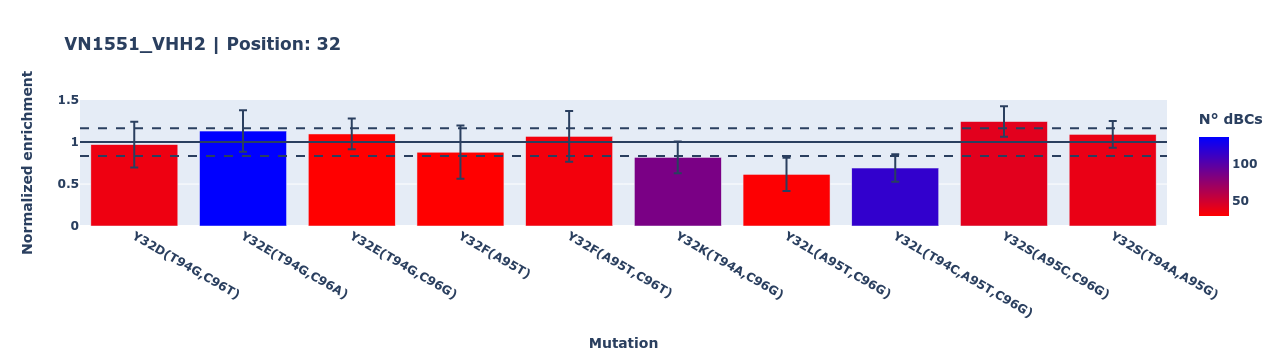

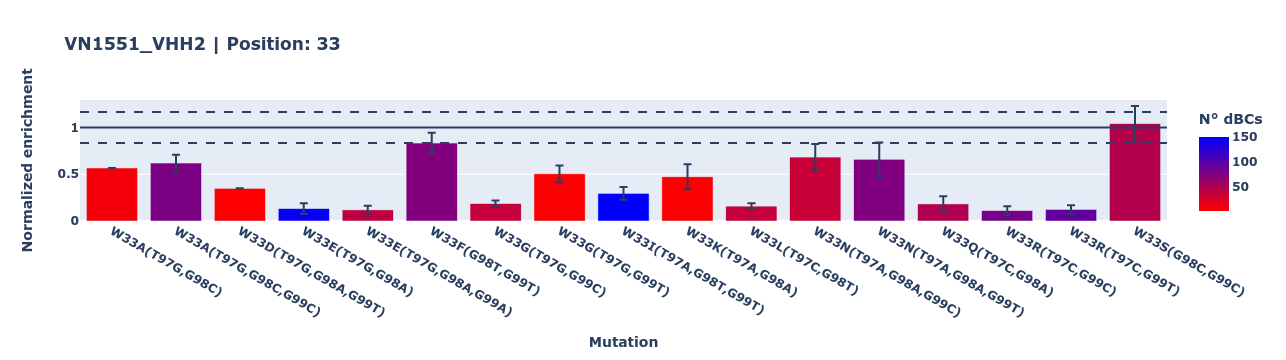

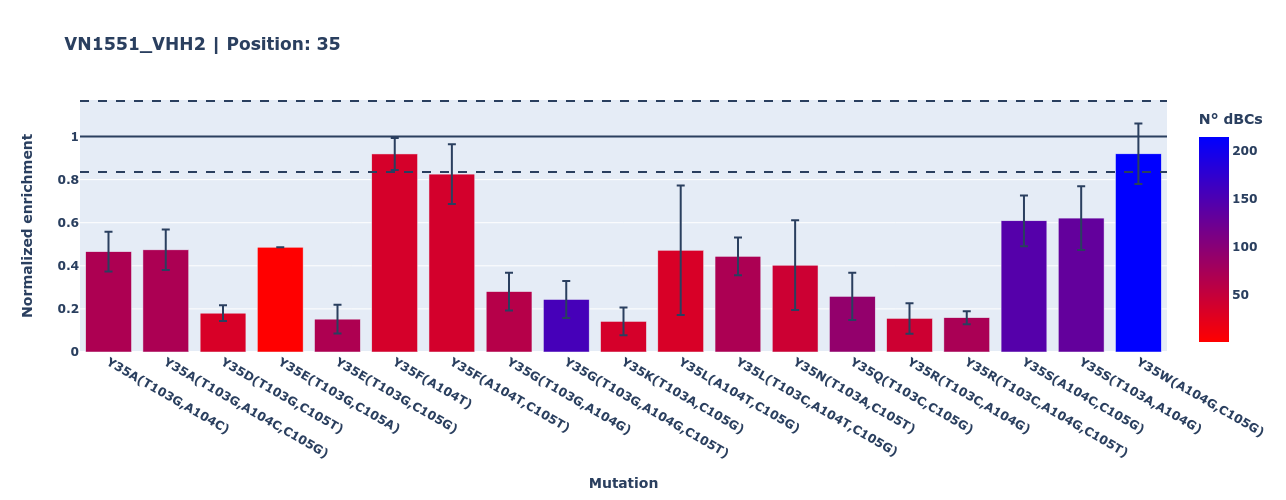

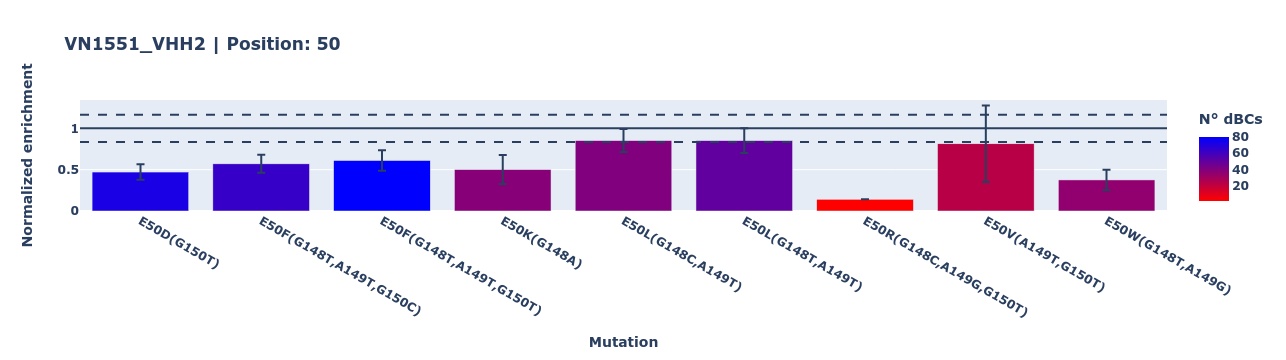

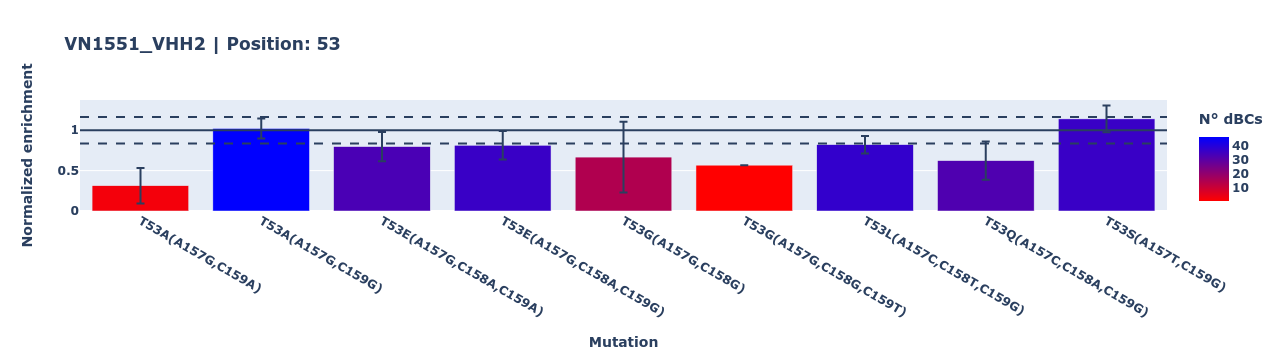

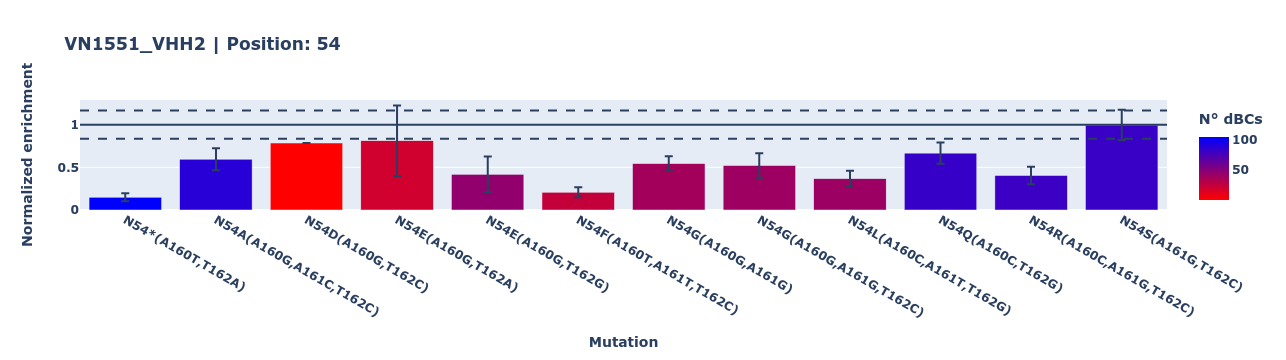

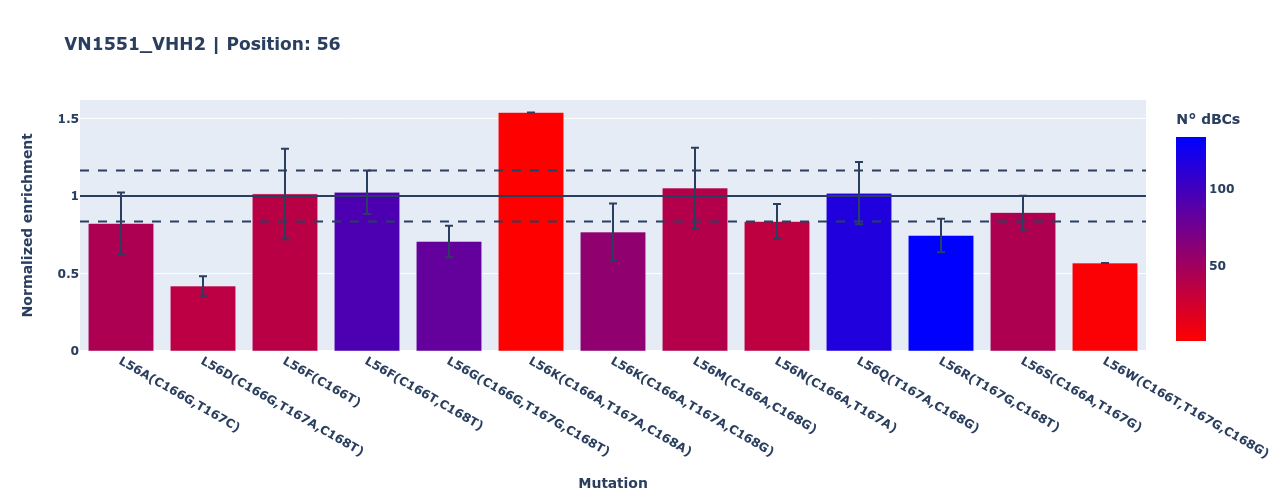

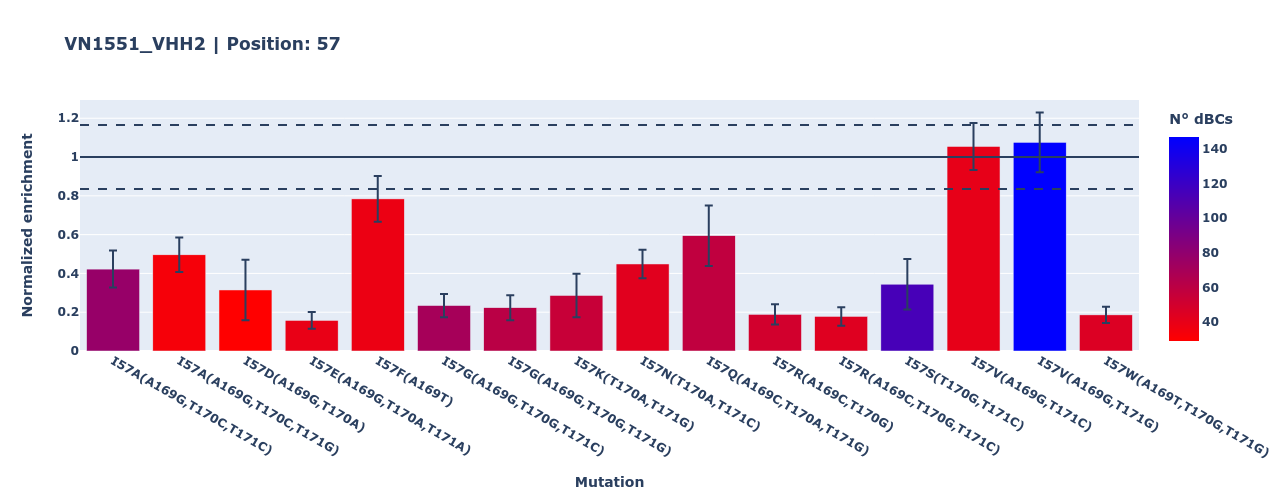

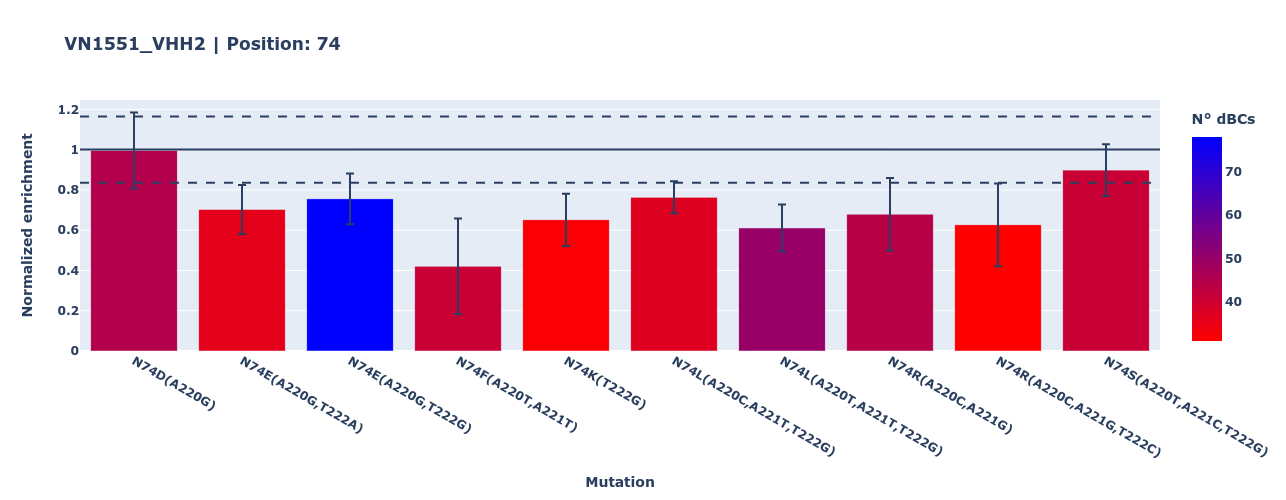

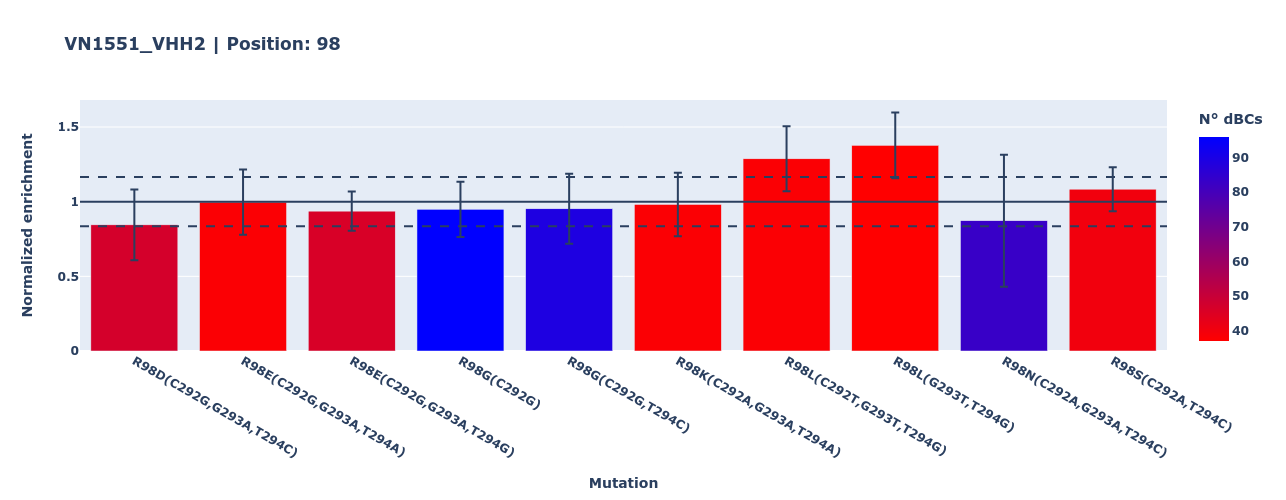

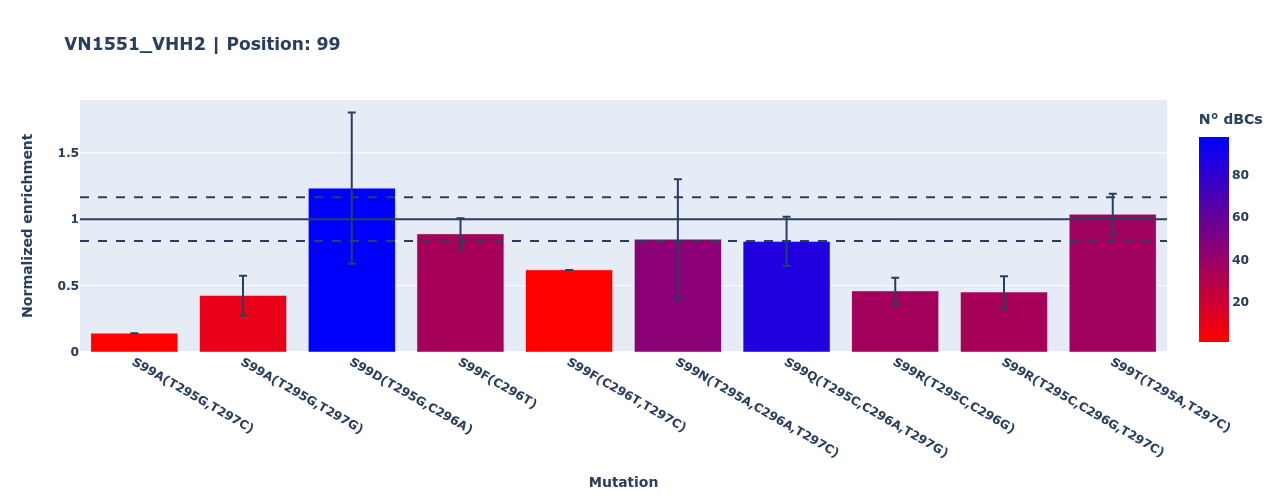

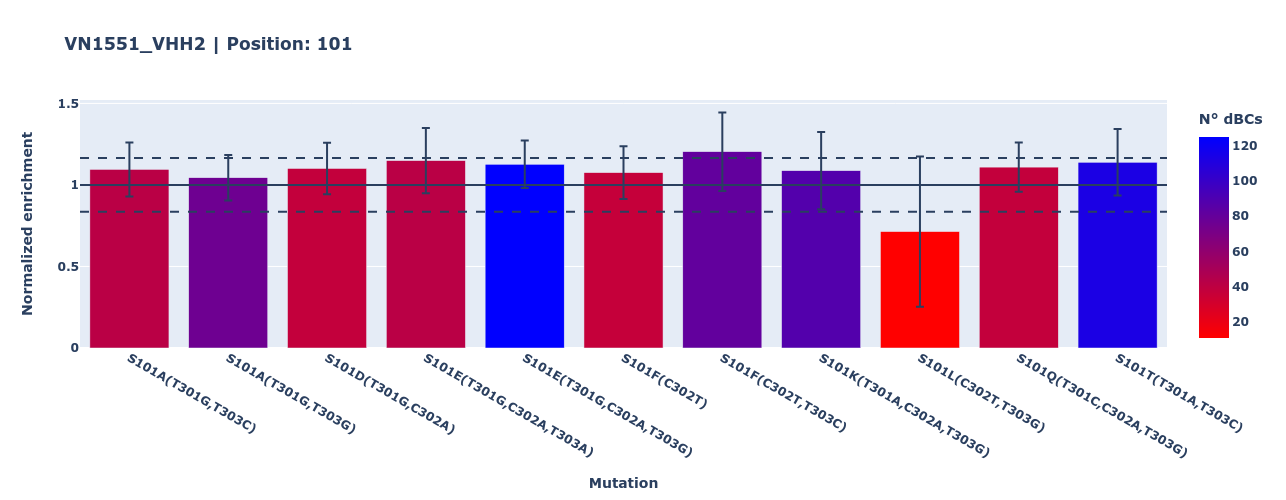

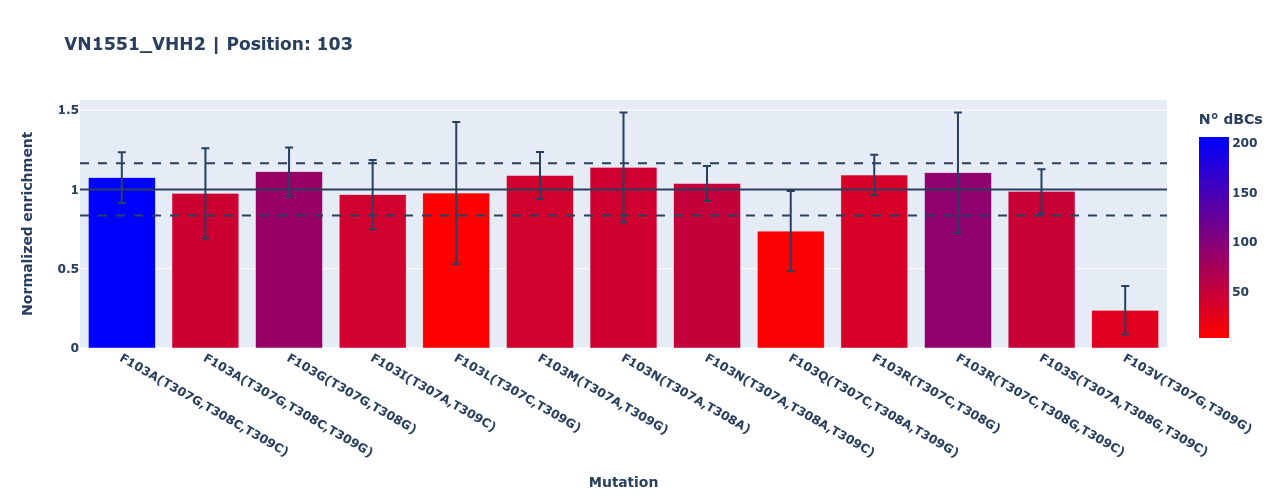

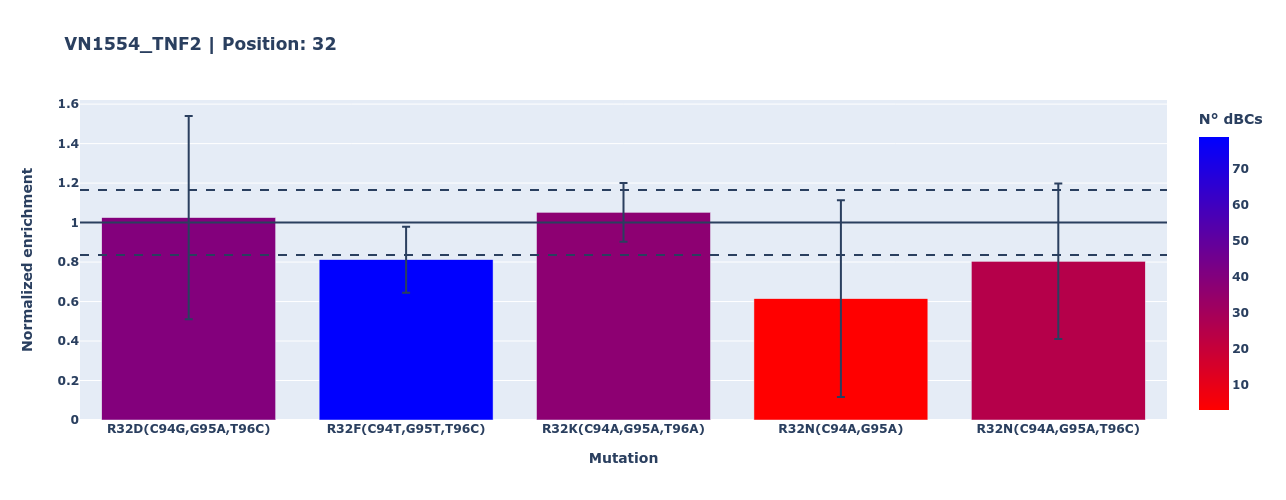

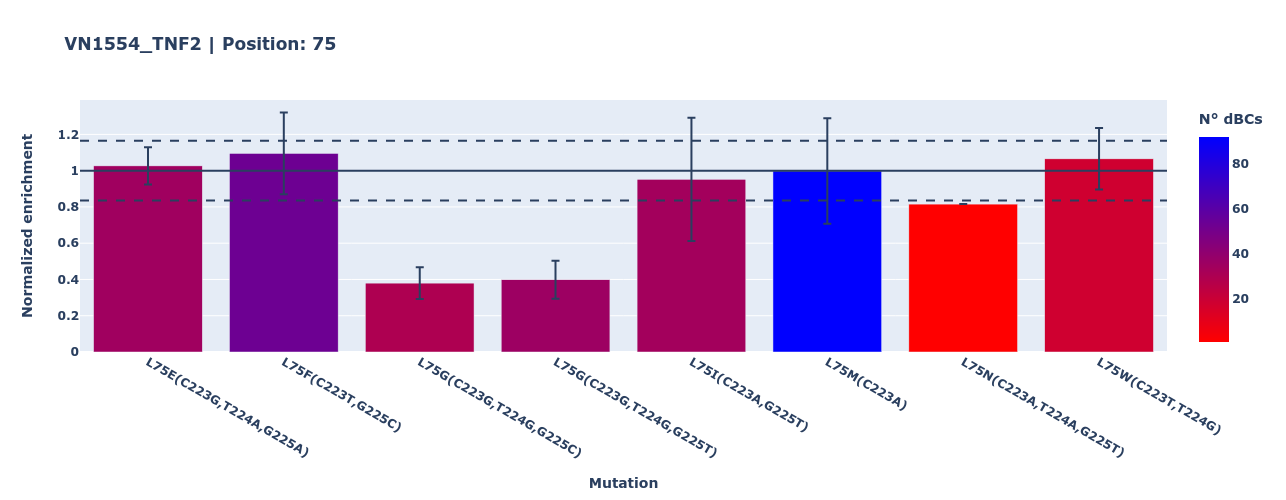

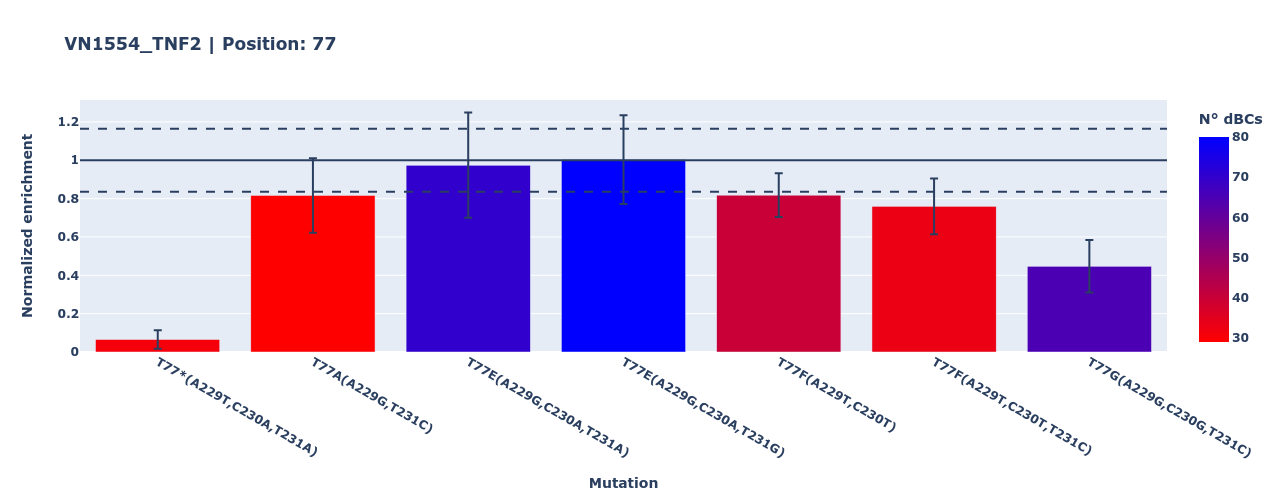

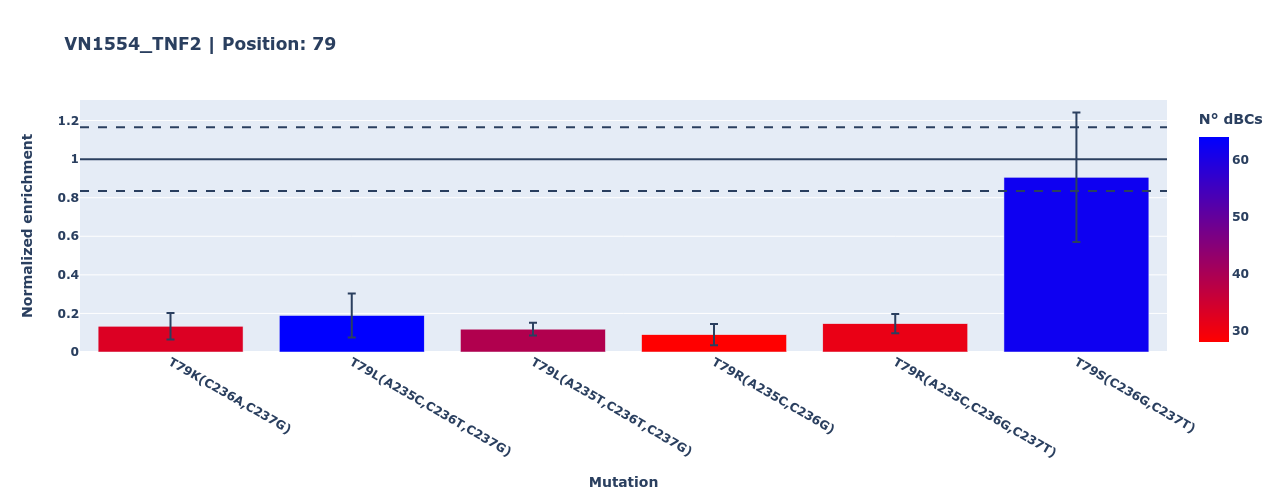

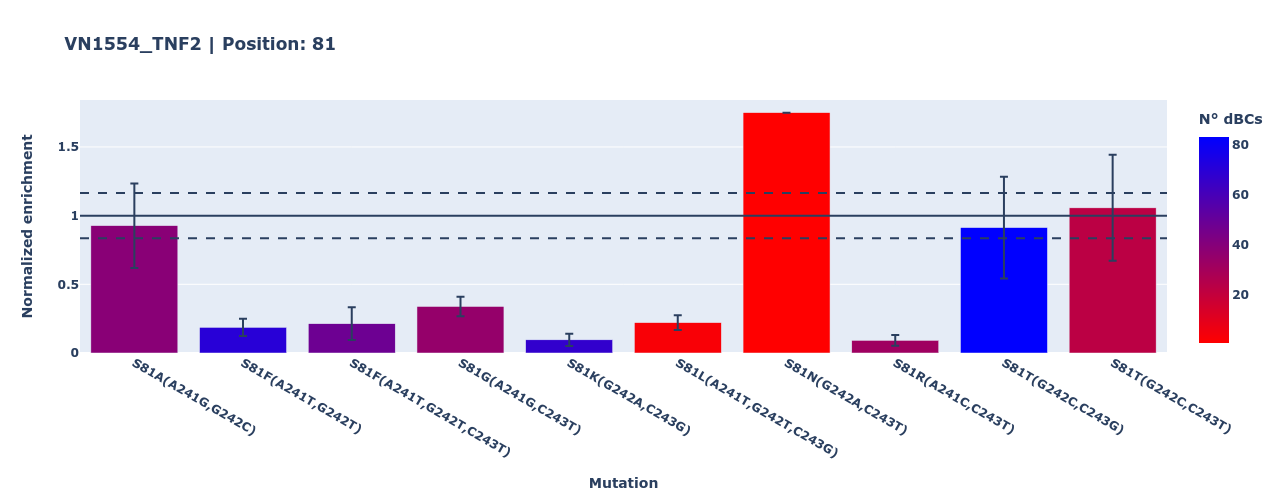

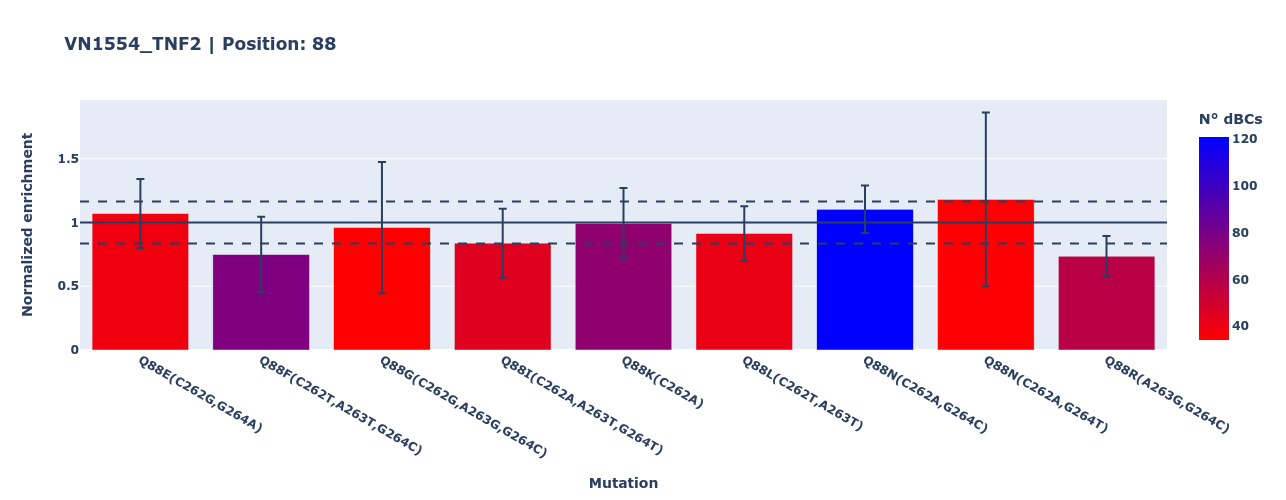

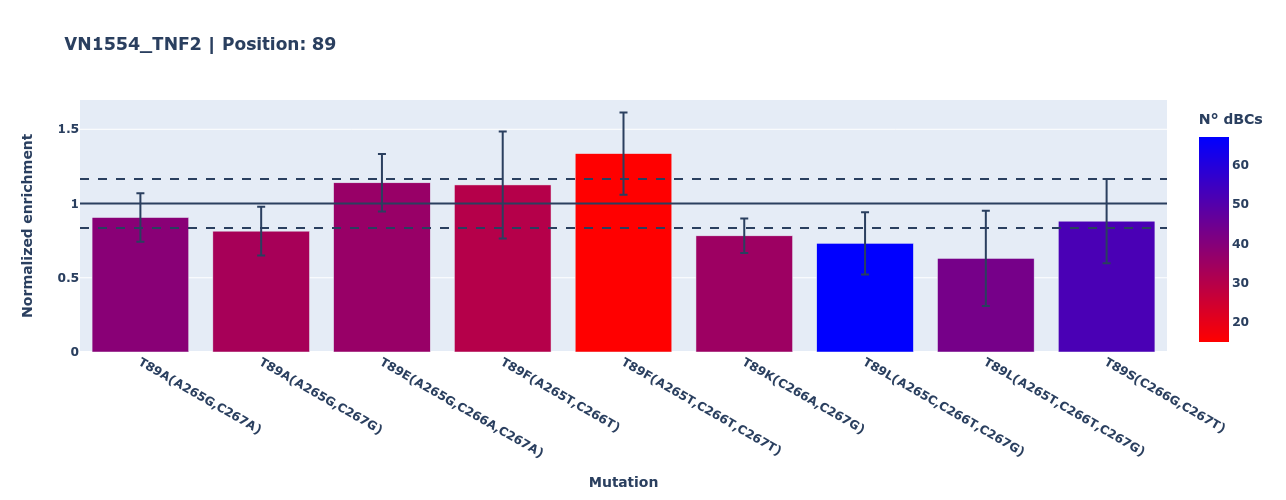

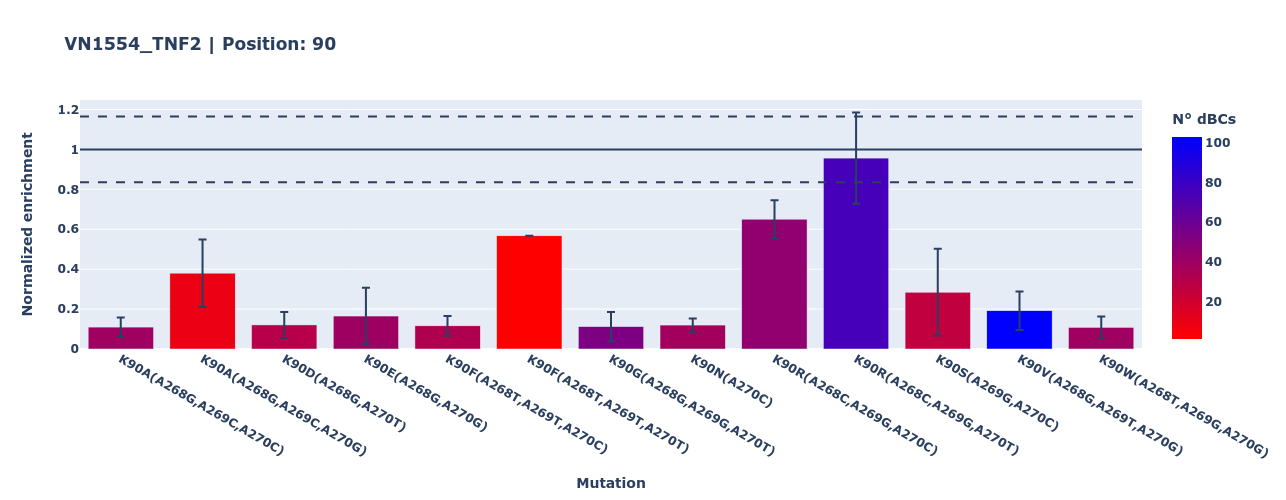

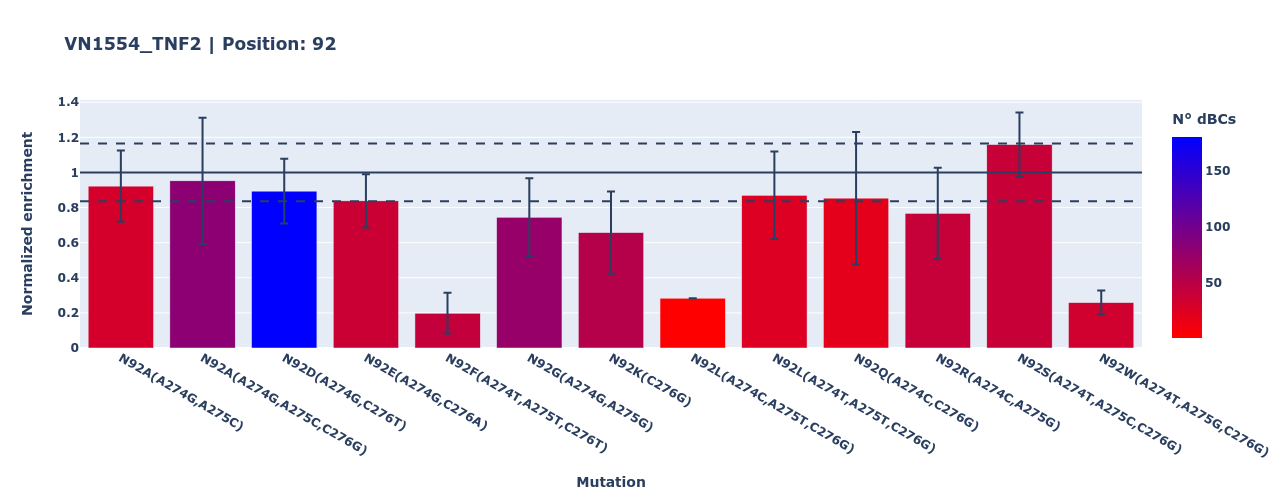

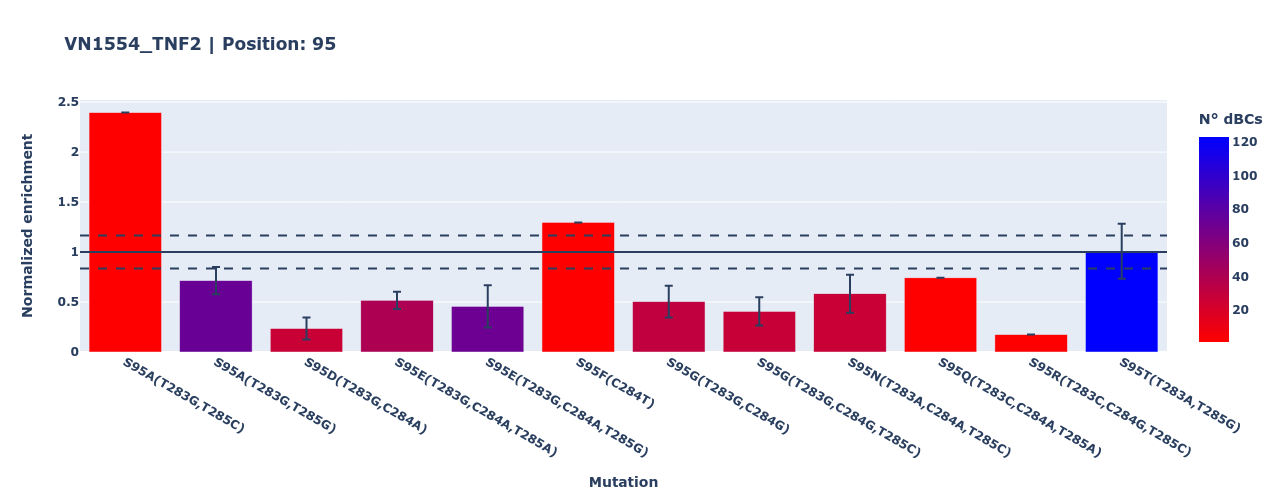

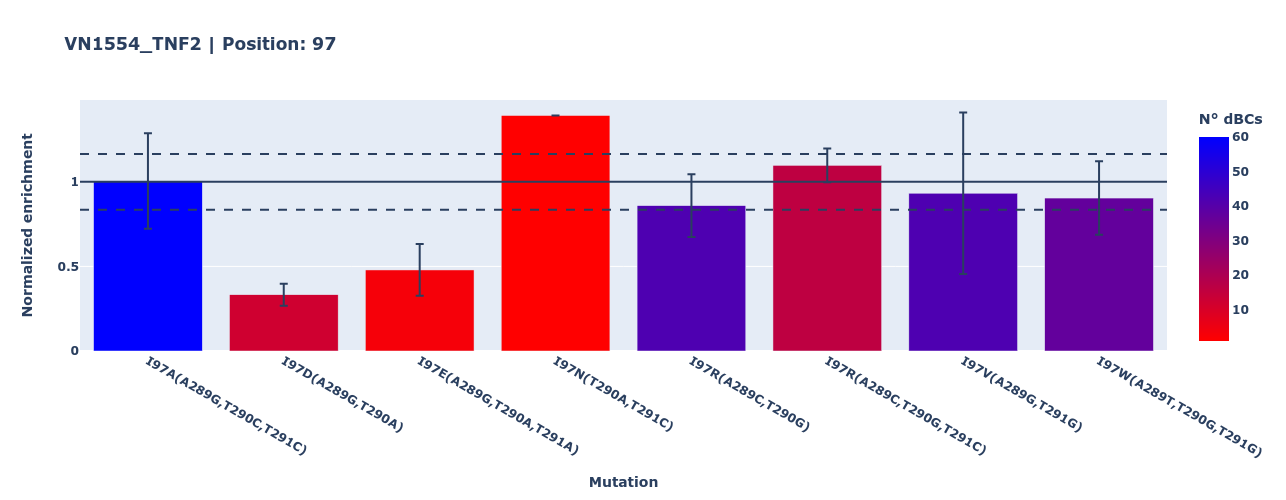

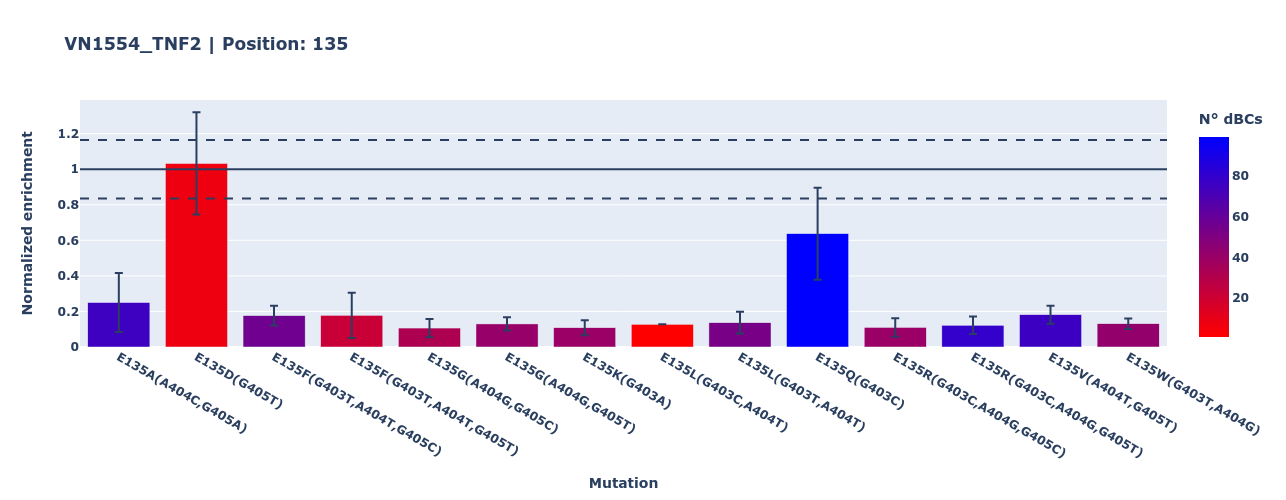

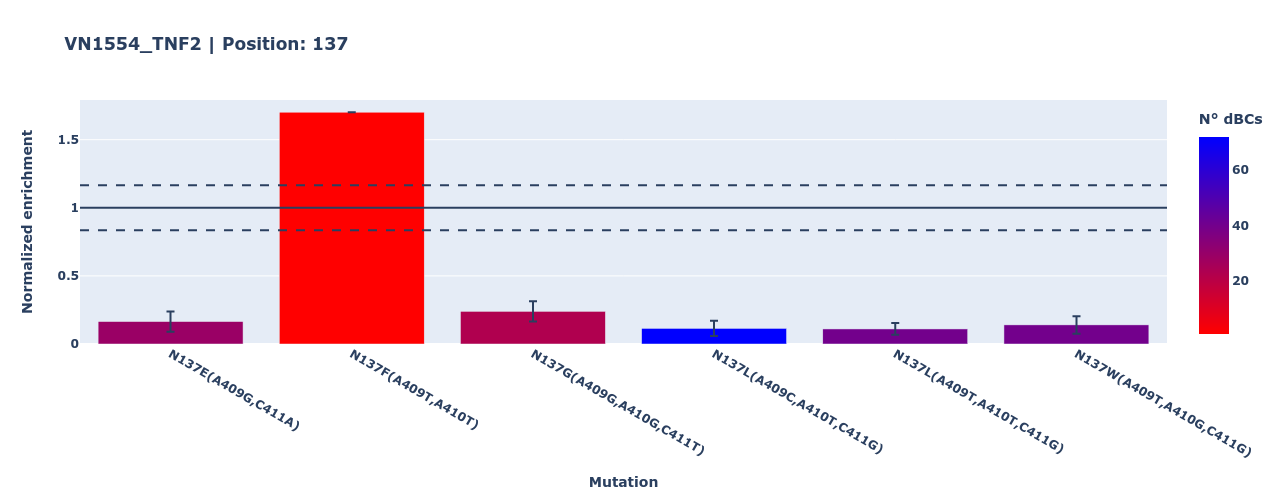

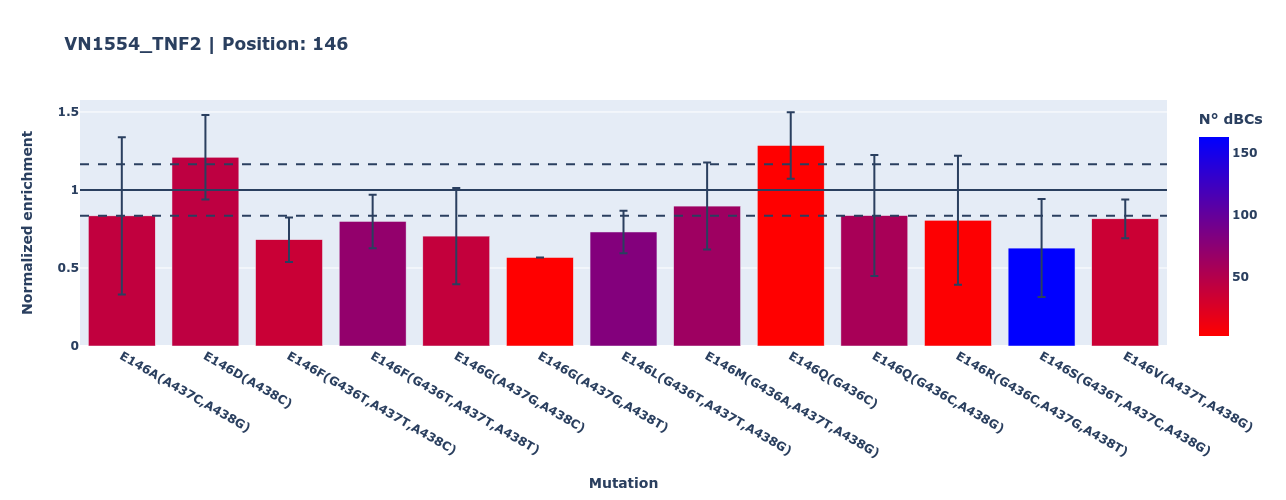

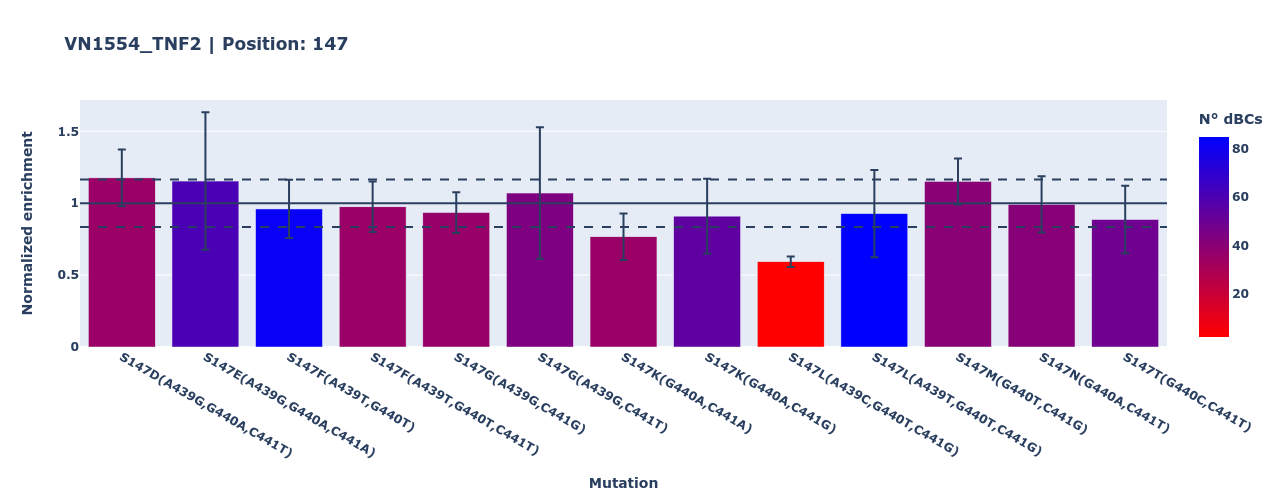

In [9]:
#plot by position information
import plotly.express as px

FigsDic = {}
for partner in ByPosDic.keys():
    PosL = sorted(ByPosDic[partner].keys())
    for pos in PosL:
        MyX = []
        MyY = []
        MyYerror = []
        dBCs = []
        MutaL = sorted(ByPosDic[partner][pos].keys())
        Title = f"{partner} | Position: {pos}"
        for muta in MutaL:
            Mean = ByPosDic[partner][pos][muta][1]
            SD = ByPosDic[partner][pos][muta][2]
            MyX.append(muta)
            MyY.append(Mean)
            MyYerror.append(SD)
            dBCs.append(len(ByPosDic[partner][pos][muta][0]))
        fig = px.bar( x=MyX, y=MyY, error_y=MyYerror, error_y_minus=MyYerror, color=dBCs, height=500, title=Title, labels={ # replaces default labels by column name
                "x": "Mutation",  "y": "Normalized enrichment", "color": "N° dBCs"
            } )
        fig.add_hline(y=1.0)
        fig.add_hline(y=1-WtSD, line_dash="dash")
        fig.add_hline(y=1+WtSD, line_dash="dash")
        fig.update_layout(coloraxis=dict(colorscale='Bluered_r'))
        FigsDic[Title] = fig
        
for Title in FigsDic.keys():
    FigsDic[Title].show()